# Build a Fine-Tuned Neural Network

The pre-trained model we are gonna use is called VGG16 ( Won the 2014 ImageNet competitions ).

Image-Net contains 1000 Images per 1000 Classes.

Note : Cats and Dogs were already part of the 1000's classes on ImageNet

# Codes Needed from Previous CNN Tut

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline 

In [2]:
train_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed\train"
valid_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed\valid"
test_path = r"C:\Local Disk\Programming\Python Projects\keras complete\dogs-vs-cats\Processed\test"

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes = ['cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), classes = ['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), classes = ['cat','dog'], batch_size=10, shuffle=False)

Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap = plt.cm.Blues):
    
    
    """
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    
    """
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap) # defining blue color-maps
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/ 2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# VGG16 Pre-processing

Subtract the mean RGB value, computed on the training set from each pixel.

In [4]:
# Downloading the model

vgg16_model = tf.keras.applications.vgg16.VGG16()

In [5]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# Our objective is just going to be change the last output layer for 2 outputs

def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params' : non_trainable_params, 'trainable_params' : trainable_params}

params = count_params(vgg16_model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544

# Just to check that the model has imported correctly

In [7]:
# checking the type of vgg16_model

type(vgg16_model) # a model from the Keras Functional API

tensorflow.python.keras.engine.functional.Functional

In [8]:
model = Sequential()

# covert the vgg16_model into a functional model

for layer in vgg16_model.layers[:-1] :
    model.add(layer)

In [9]:
model.summary() # Last layer not included

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [10]:
params = count_params(model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 134260544 # if not asset, or if assert fails an 'Assertion Error' is returned

In [11]:
for layer in model.layers :
    layer.trainable = False # Freeze the weights and biases in the model for all layer

In [12]:
model.add(Dense(units=2, activation='softmax')) # only trainable layer in the entire model

In [13]:
model.summary() # our model now has 8,194 trainable parameters only

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Training the Fine-Tuned VGG16 Model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(x=train_batches, validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
1800/1800 - 86s - loss: 0.0724 - accuracy: 0.9716 - val_loss: 0.0493 - val_accuracy: 0.9814
Epoch 2/10
1800/1800 - 88s - loss: 0.0406 - accuracy: 0.9851 - val_loss: 0.0448 - val_accuracy: 0.9826
Epoch 3/10
1800/1800 - 114s - loss: 0.0321 - accuracy: 0.9883 - val_loss: 0.0472 - val_accuracy: 0.9830
Epoch 4/10
1800/1800 - 115s - loss: 0.0263 - accuracy: 0.9904 - val_loss: 0.0480 - val_accuracy: 0.9818
Epoch 5/10
1800/1800 - 136s - loss: 0.0213 - accuracy: 0.9925 - val_loss: 0.0464 - val_accuracy: 0.9846
Epoch 6/10
1800/1800 - 173s - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0474 - val_accuracy: 0.9842
Epoch 7/10
1800/1800 - 172s - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0510 - val_accuracy: 0.9826
Epoch 8/10
1800/1800 - 189s - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.0498 - val_accuracy: 0.9842
Epoch 9/10
1800/1800 - 208s - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0523 - val_accuracy: 0.9836
Epoch 10/10
1800/1800 - 265s - loss: 0.0085 - accuracy: 0.9981 - v

# Predict using the Fine-Tuned VGG16 Model

In [16]:
predictions = model.predict(x=test_batches, verbose=2)

200/200 - 20s


In [17]:
cm = confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

Confusion matrix, without normalization
[[985  15]
 [  7 993]]


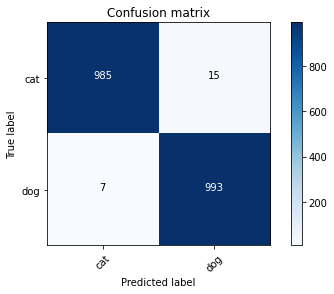

In [19]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Confusion matrix")